In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


In [228]:
# load raw data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")
# fft and smooth our data to reduce noise
data_fft = fft.fft(data)[:,:,::2]
# load receiver positions
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")
# load transmitter positions
tx_positions = np.load("../Data/RayTracingData/Remcom_4x4_txpos.npy")
# load Phi and Theta
phi = np.load('../Data/RayTracingData/Remcom_4x4_AoA_phi.npy')
theta = np.load('../Data/RayTracingData/Remcom_4x4_AoA_theta.npy')

In [229]:
def standarize(x):
    return (np.array(x)-np.mean(x))/np.std(x)

def euclidean_distance(x1,x2):
    return np.linalg.norm(x1-x2)

def drop_top_right(data, rx_positions):
    idxx = rx_positions[:,0] > 300
    idxy = rx_positions[:,1] > 150
    idx = np.logical_and(idxx, idxy)
    good_idcs = ~idx
    return data[good_idcs]
def normalize(x):
    return (x - x.min(0))/x.ptp(0)

def fillna(x, value=0):
    x[np.where(np.isnan(x))] = value
    return x

def zero_padding_as(x, target):
    width = (target.shape[2] - x.shape[2])//2
    x = np.pad(x, (width,width))
    return x

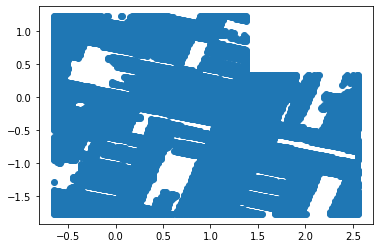

In [230]:
Y = drop_top_right(standarize(rx_positions)[:,:2], rx_positions)
plt.scatter(Y[:,0], Y[:,1])

In [231]:
X_1 = standarize(drop_top_right(data_fft, rx_positions))
X_1 = np.hstack([np.real(X_1), np.imag(X_1)])
#X_2 = zero_padding_as(fillna(standarize(drop_top_right(phi, rx_positions)))[10:], X_1)
#X_3 = zero_padding_as(fillna(standarize(drop_top_right(theta, rx_positions)))[10:], X_1)
X = np.hstack([X_1])

In [232]:
train_X, test_X, train_y, test_y = train_test_split(X,Y, test_size=0.15)

In [233]:
class MyDataSet(Dataset):
    def __init__(self, X,y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
    def __len__(self):
        return self.X.shape[0]
    def channels(self):
        return self.X.shape[1]
    def timesteps(self):
        return self.X.shape[2]
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [265]:
train_DS = MyDataSet(train_X, train_y)
test_DS = MyDataSet(test_X, test_y)

train_loader = DataLoader(train_DS, batch_size=32, drop_last=True, shuffle=True)
test_loader = DataLoader(test_DS, batch_size=32, drop_last=True)

In [266]:
train_DS.channels()

32

In [267]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_DS.channels(), 
                               out_channels=128, 
                               kernel_size=8,
                              stride=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.lin1 = nn.Linear(160, 64)
        self.lin2 = nn.Linear(64, 32)
        self.z_Loc = nn.Linear(32,latent_dim)
        self.z_scale = nn.Linear(32,latent_dim)
        
    def forward(self, x):
        x = F.normalize(F.selu(self.conv1(x)))
        x = F.normalize(F.selu(self.conv2(x)))
        x = F.normalize(F.selu(self.conv3(x)))
        x = torch.flatten(x,1)
        x = F.selu(self.lin1(x))
        x = F.selu(self.lin2(x))

        z_loc = F.softplus(self.z_Loc(x))
        z_scale = torch.exp(self.z_scale(x))
        return z_loc, z_scale
    

In [268]:
# test encoder
enc = Encoder()
sample = train_DS[:1][0]
latent = enc(sample)

In [269]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(latent_dim ,32)
        self.lin2 = nn.Linear(32, 64)
        self.lin3 = nn.Linear(64, 160)
        
        self.deconv1 = nn.ConvTranspose1d(32, 64, 2, 2)
        self.deconv2 = nn.ConvTranspose1d(64, 128, 4, 2)
        self.deconv3 = nn.ConvTranspose1d(128, train_DS.channels(), 8, 2)   
        
    def forward(self, x):
        x = F.selu(self.lin1(x))
        x = F.selu(self.lin2(x))        
        x = F.selu(self.lin3(x))
        x = x.view(x.shape[0], 32, 5)
        x = F.selu(self.deconv1(x))
        x = F.selu(self.deconv2(x))        
        x = F.selu(self.deconv3(x))
        
        return x

In [270]:
# test decoder
dec = Decoder(2)
reconstructed = dec(latent[0])
reconstructed.shape, sample.shape

(torch.Size([1, 32, 50]), torch.Size([1, 32, 50]))

In [271]:
# define the model p(x|z)p(z)
def model(self, x):
    # register PyTorch module `decoder` with Pyro
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        # decode the latent code z
        recostructed = self.decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(reconstructed).to_event(1), obs=x.reshape(-1, torch.flatten.shape[1]))


In [272]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder.forward(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


In [273]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            reconstructed = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(torch.flatten(reconstructed)).to_event(1), 
                            obs=torch.flatten(x).shape[0])

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        reconstructed = self.decoder(z)
        return reconstructed


In [274]:
vae = VAE(2)
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [275]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in tqdm(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in tqdm(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [276]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False
smoke_test = False
# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5
# clear param store
pyro.clear_param_store()

In [277]:
# setup the VAE
vae = VAE(2, use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))



[epoch 000]  average training loss: -39708121063.8692



[epoch 000] average test loss: -41673376254.3420



[epoch 001]  average training loss: -41752298710.4191



[epoch 002]  average training loss: -41752298710.4305



[epoch 003]  average training loss: -41752298710.4164



[epoch 004]  average training loss: -41752298710.4267


KeyboardInterrupt: 

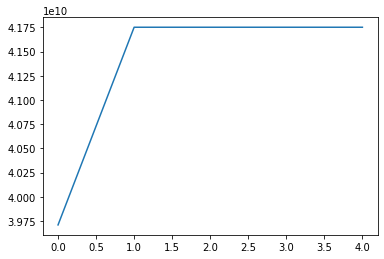

In [278]:
plt.plot(train_elbo)

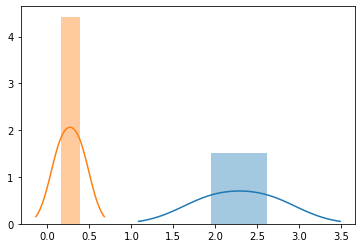

In [279]:
import seaborn as sns
sns.distplot(vae.encoder(sample)[0].detach())
sns.distplot(vae.encoder(sample)[1].detach())

In [280]:
enc = vae.encoder(sample)

In [281]:
enc[1]

tensor([[0.3819, 0.1560]], grad_fn=<ExpBackward>)

In [282]:
svi.guide(sample)

In [283]:
d = pyro.get_param_store().get_all_param_names()

In [293]:
reconstructed = vae.reconstruct(sample)

In [294]:
diff = reconstructed.detach() - sample

In [297]:
latent = vae.encoder(test_DS[:][0])

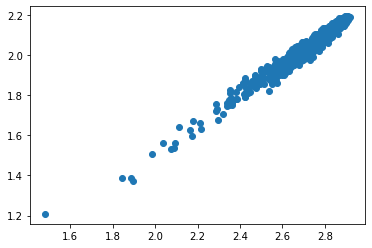

In [301]:
plt.scatter(latent[0][:,0].detach(), latent[0][:,1].detach())